#Library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.7 MB/s eta 0:00:00


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from torchvision.models import resnet152, resnet50
from PIL import Image
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import albumentations as A
import cv2
import warnings
warnings.filterwarnings('ignore')


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_r=pd.read_csv('/content/drive/MyDrive/data/train_r.csv')
train_p=pd.read_csv('/content/drive/MyDrive/data/train_p.csv')

valid_r=pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')
valid_p=pd.read_csv('/content/drive/MyDrive/data/valid_p.csv')

test_r=pd.read_csv('/content/drive/MyDrive/data/test_r.csv')
test_p=pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

In [5]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

#Config

In [72]:
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#batch size
batch_size = 16

# params
epoch = 20
patience = 2
factor = 0.5
# loss function
loss_fn = nn.CrossEntropyLoss().to(device)

res_lr = 0.001
transformers = transforms=A.Compose(
            [A.Resize(255, 255, always_apply=True),
             A.Normalize(max_pixel_value=255.0, always_apply=True)])

n_train_p=len(train_p)
n_valid_p=len(valid_p)
n_train_r=len(train_r)
n_valid_r=len(valid_r)

train_img_p = '/content/drive/MyDrive/data/train_P_image/'
test_img_p = '/content/drive/MyDrive/data/test_P_image/'

train_img_r = '/content/drive/MyDrive/data/train_R_image/'
test_img_r = '/content/drive/MyDrive/data/test_R_image/'


# Model

In [17]:
class AudioCNNDataset(Dataset):
    def __init__(self, img_names, img_dir, target, transforms):
      super(AudioCNNDataset, self).__init__()
      self.img_names = img_names+'.jpg'
      self.img_dir = img_dir
      self.target = target
      self.transforms = transforms

    def __getitem__(self, index):
      item = {}
      image = cv2.imread(f"{self.img_dir}{self.img_names[index]}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = self.transforms(image=image)['image']
      item['target'] = self.target[index]
      item['image'] = torch.tensor(image).permute(2, 0, 1).float()

      return item


    def __len__(self):
      return len(self.img_names)


def create_audio_loader(df, img_dir, shuffle=True):
  ds = AudioCNNDataset(target=df['index'].values,
                       img_names= df['file_name'].values,
                       img_dir=img_dir,
                       transforms=transforms)

  return DataLoader(ds,
                    batch_size=batch_size
                    ,shuffle=shuffle)

In [18]:
class Resnet50(nn.Module):

  def __init__(self, n_classes):
    super(Resnet50, self).__init__()
    self.premodel = resnet50(weights="IMAGENET1K_V2")
    modules=list(self.premodel.children())[:-1]
    self.model=nn.Sequential(*modules)
    self.fc=nn.Linear(2048, n_classes)

  def forward(self, image):
    out = self.model(image)
    output=out.flatten(1)
    logits=self.fc(output)
    probas = F.softmax(logits, dim=1)

    return logits, probas

In [23]:
def train_epoch(model, train_dataloader, optimizer,n_train):
    model = model.train() # puts the model in training mode
    correct=0
    running_loss = 0.0
    process_bar = tqdm(train_dataloader)
    for batch in process_bar:
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)
      optimizer.zero_grad() # clear the gradients in model parameters
      logits, probas = model(audio) # put data into model to predict
      loss = loss_fn(logits, targets) # calculate loss between prediction and true labels
      loss.backward() # back propagation: pass the loss
      optimizer.step()  # iterate over all parameters in the model with requires_grad=True and update their weights.
      # compute training statistics
      _, predicted = torch.max(logits, 1)
      correct += (predicted == targets).sum().item()
      running_loss += loss.item() # sum total loss in current epoch for print later
      process_bar.set_postfix(train_loss=loss.item())

    avg_loss = running_loss / n_train
    avg_acc = correct / n_train

    return avg_acc,avg_loss

def eval_model(model, val_dataloader, n_valid):
    model=model.eval() # puts the model in validation mode
    loss_val = 0.0
    correct_val = 0
    process_bar = tqdm(val_dataloader)
    for batch in process_bar:
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)
      logits, probas = model(audio)
      loss = loss_fn(logits, targets)
      _, predicted = torch.max(logits, 1)
      correct_val += (predicted == targets).sum().item()
      loss_val += loss.item()
      process_bar.set_postfix(val_loss=loss.item())
    avg_loss_val = loss_val / n_valid
    avg_acc_val = correct_val /n_valid

    return avg_acc_val,avg_loss_val

def get_predictions(model, test_dataloader):
  model=model.eval()
  predictions=[]
  real_values=[]
  with torch.no_grad():
    for batch in tqdm(test_dataloader):
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)

      logits, probas = model(audio)
      _, predicted_labels = torch.max(probas, 1)

      predictions.extend(predicted_labels)
      real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, real_values

In [20]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Researcher

In [73]:
train_dataloader = create_audio_loader(train_r, train_img_r, shuffle=True)
val_dataloader = create_audio_loader(valid_r, test_img_r ,shuffle=False)
test_dataloader = create_audio_loader(test_r, test_img_r ,shuffle=False)

In [74]:
model=Resnet50(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=res_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)

for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader,
                                       optimizer,
                                       n_train_r)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader, n_valid_r)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_res50.pt')

Epoch 1/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.40it/s, train_loss=1.35]


Train loss 0.07931243907762701 accuracy 0.5473047304730473


100%|██████████| 15/15 [00:01<00:00, 13.28it/s, val_loss=1.53]


Val loss 0.1066428898719319 accuracy 0.4473684210526316

Epoch 2/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.39it/s, train_loss=1.15]


Train loss 0.07485380257316941 accuracy 0.583058305830583


100%|██████████| 15/15 [00:01<00:00, 14.09it/s, val_loss=0.995]


Val loss 0.0853142001126942 accuracy 0.5307017543859649

Epoch 3/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.45it/s, train_loss=0.725]


Train loss 0.0706350018482397 accuracy 0.6056105610561056


100%|██████████| 15/15 [00:01<00:00, 14.18it/s, val_loss=1.38]


Val loss 0.07706010237074735 accuracy 0.5526315789473685

Epoch 4/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.36it/s, train_loss=1.25]


Train loss 0.06625227664563522 accuracy 0.6149614961496149


100%|██████████| 15/15 [00:01<00:00, 14.15it/s, val_loss=1.67]


Val loss 0.07861080765724182 accuracy 0.5789473684210527

Epoch 5/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.44it/s, train_loss=1.17]


Train loss 0.062426047700859924 accuracy 0.6226622662266227


100%|██████████| 15/15 [00:01<00:00, 14.72it/s, val_loss=1.29]


Val loss 0.08040564990880196 accuracy 0.5131578947368421

Epoch 6/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.47it/s, train_loss=0.912]


Train loss 0.057011360185767954 accuracy 0.66996699669967


100%|██████████| 15/15 [00:01<00:00, 14.08it/s, val_loss=8.9]


Val loss 0.2591844127889265 accuracy 0.44298245614035087

Epoch 7/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.42it/s, train_loss=0.436]


Train loss 0.03706992386427387 accuracy 0.7805280528052805


100%|██████████| 15/15 [00:01<00:00, 13.82it/s, val_loss=2.24]


Val loss 0.13841687168991357 accuracy 0.5131578947368421

Epoch 8/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.35it/s, train_loss=0.796]


Train loss 0.019327124427057335 accuracy 0.900990099009901


100%|██████████| 15/15 [00:01<00:00, 13.99it/s, val_loss=4.94]


Val loss 0.2296154624537418 accuracy 0.4166666666666667

Epoch 9/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.37it/s, train_loss=0.414]


Train loss 0.013978779774950151 accuracy 0.9312431243124313


100%|██████████| 15/15 [00:01<00:00, 14.41it/s, val_loss=5.71]


Val loss 0.27197653787177906 accuracy 0.4605263157894737

Epoch 10/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.42it/s, train_loss=0.0631]


Train loss 0.00369977975101287 accuracy 0.988998899889989


100%|██████████| 15/15 [00:01<00:00, 13.33it/s, val_loss=1.02]


Val loss 0.12434797328815125 accuracy 0.5921052631578947

Epoch 11/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.41it/s, train_loss=0.00135]


Train loss 0.0009576079723290993 accuracy 0.9983498349834984


100%|██████████| 15/15 [00:01<00:00, 13.24it/s, val_loss=0.544]


Val loss 0.1264704152157432 accuracy 0.5789473684210527

Epoch 12/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.37it/s, train_loss=0.000498]


Train loss 0.0003754717747664706 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 13.42it/s, val_loss=0.352]


Val loss 0.14675547626980565 accuracy 0.5745614035087719

Epoch 13/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.44it/s, train_loss=0.00147]


Train loss 0.0001812515835815885 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 14.30it/s, val_loss=0.912]


Val loss 0.15197291290550902 accuracy 0.5745614035087719

Epoch 14/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.42it/s, train_loss=0.0394]


Train loss 0.00016997126821568517 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 14.45it/s, val_loss=0.931]


Val loss 0.16156161615723058 accuracy 0.5657894736842105

Epoch 15/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.41it/s, train_loss=0.00156]


Train loss 0.00014868567267421794 accuracy 0.9994499449944995


100%|██████████| 15/15 [00:01<00:00, 14.05it/s, val_loss=0.737]


Val loss 0.15789400694663064 accuracy 0.5657894736842105

Epoch 16/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.35it/s, train_loss=0.00342]


Train loss 8.721958888565037e-05 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 14.24it/s, val_loss=0.884]


Val loss 0.1636754104442764 accuracy 0.5657894736842105

Epoch 17/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.42it/s, train_loss=0.00048]


Train loss 0.00010814747272486562 accuracy 0.9994499449944995


100%|██████████| 15/15 [00:01<00:00, 14.16it/s, val_loss=1.01]


Val loss 0.16163847111819082 accuracy 0.5877192982456141

Epoch 18/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.38it/s, train_loss=0.00433]


Train loss 7.251796213464237e-05 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 14.32it/s, val_loss=0.963]


Val loss 0.15956885197706389 accuracy 0.5745614035087719

Epoch 19/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.40it/s, train_loss=0.00874]


Train loss 5.450989126432195e-05 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 14.12it/s, val_loss=0.676]


Val loss 0.16623063908334365 accuracy 0.5657894736842105

Epoch 20/20
----------


100%|██████████| 114/114 [00:13<00:00,  8.33it/s, train_loss=0.00162]


Train loss 8.148246737913208e-05 accuracy 1.0


100%|██████████| 15/15 [00:01<00:00, 13.92it/s, val_loss=0.828]


Val loss 0.15582653827834547 accuracy 0.5614035087719298



In [75]:
with torch.no_grad():
    y_pred, y_test=get_predictions(model, test_dataloader)

100%|██████████| 15/15 [00:00<00:00, 15.34it/s]


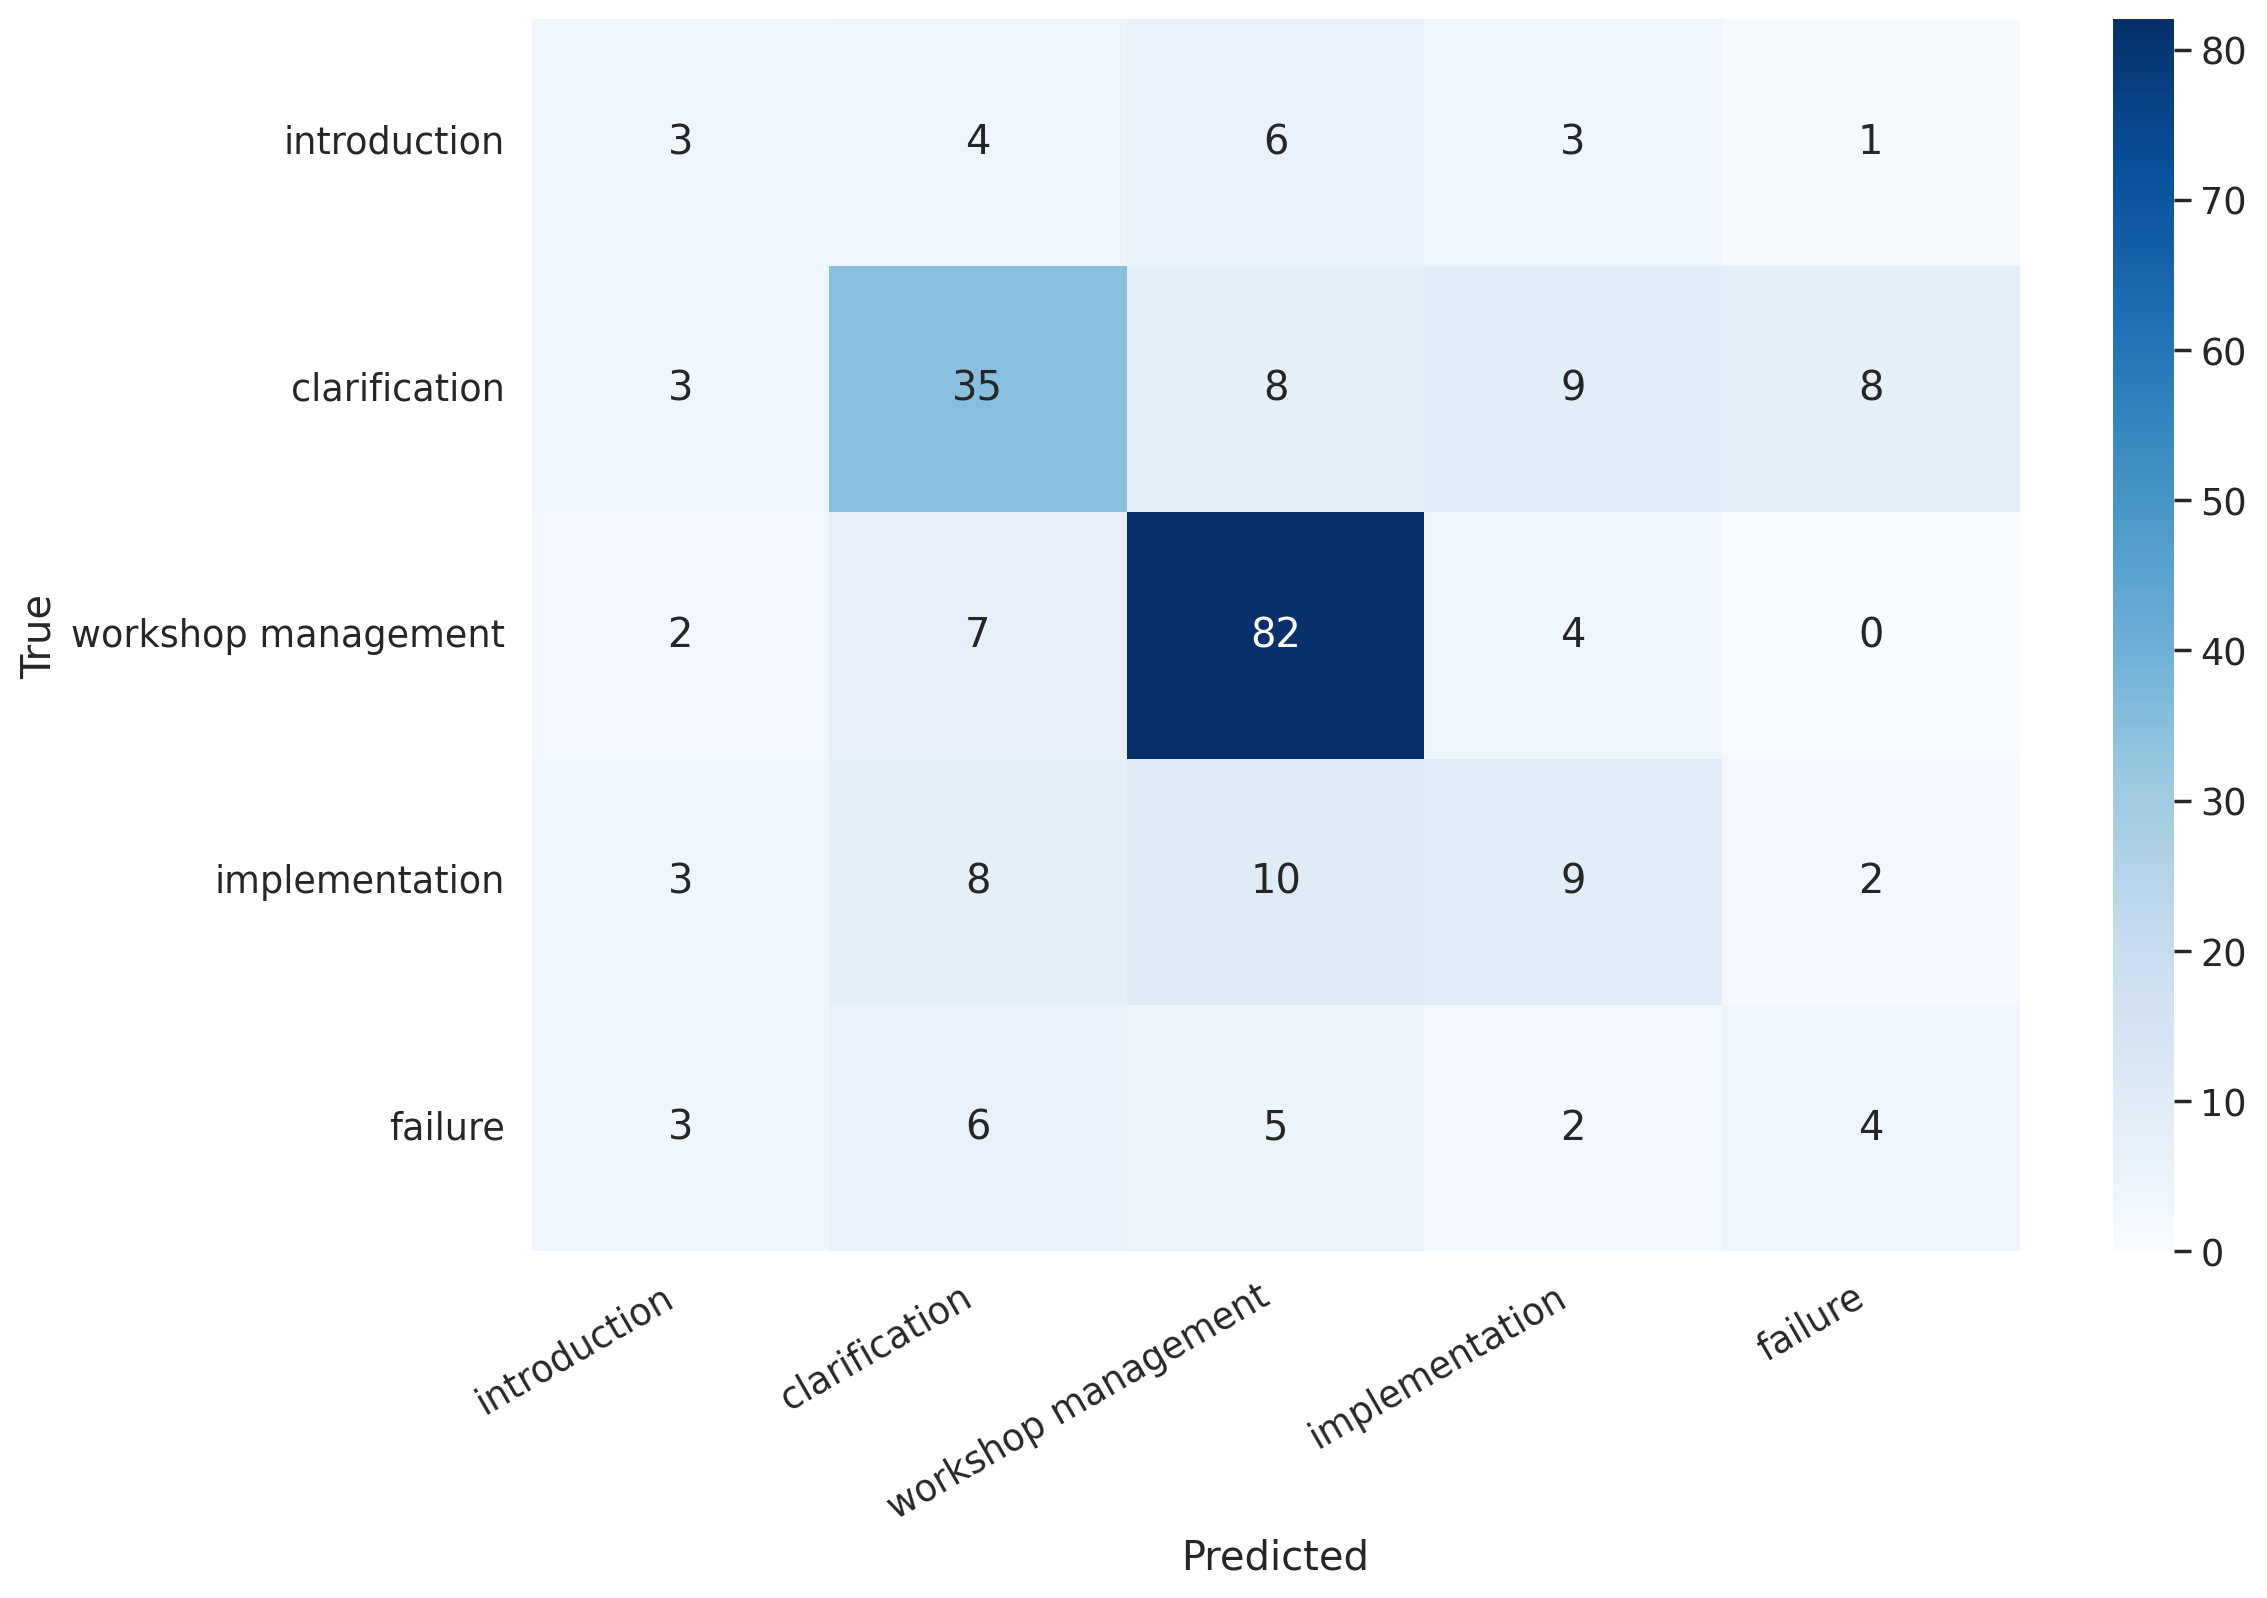

In [76]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [77]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.21      0.18      0.19        17
      clarification       0.58      0.56      0.57        63
workshop management       0.74      0.86      0.80        95
     implementation       0.33      0.28      0.31        32
            failure       0.27      0.20      0.23        20

           accuracy                           0.59       227
          macro avg       0.43      0.42      0.42       227
       weighted avg       0.56      0.59      0.57       227



# Participant


In [85]:
train_dataloader_p = create_audio_loader(train_p, train_img_p, shuffle=True)
val_dataloader_p = create_audio_loader(valid_p, test_img_p ,shuffle=False)
test_dataloader_p = create_audio_loader(test_p, test_img_p ,shuffle=False)

In [86]:
model=Resnet50(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=res_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=0.4)

for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader_p,
                                       optimizer,
                                       n_train_p)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader_p, n_valid_p)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_res50.pt')


Epoch 1/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.22it/s, train_loss=1.18]


Train loss 0.09449990022750128 accuracy 0.29330572808833677


100%|██████████| 12/12 [00:00<00:00, 13.77it/s, val_loss=1.53]


Val loss 0.12118449708917639 accuracy 0.26373626373626374

Epoch 2/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.29it/s, train_loss=1.31]


Train loss 0.09310313419607938 accuracy 0.32712215320910976


100%|██████████| 12/12 [00:00<00:00, 13.20it/s, val_loss=1.56]


Val loss 0.09853629162023356 accuracy 0.33516483516483514

Epoch 3/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.20it/s, train_loss=1.26]


Train loss 0.09137098710235848 accuracy 0.3333333333333333


100%|██████████| 12/12 [00:00<00:00, 12.70it/s, val_loss=1.81]


Val loss 0.10176280239126184 accuracy 0.3021978021978022

Epoch 4/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.29it/s, train_loss=1.18]


Train loss 0.09106572674750624 accuracy 0.35403726708074534


100%|██████████| 12/12 [00:00<00:00, 13.96it/s, val_loss=1.65]


Val loss 0.10049944199048556 accuracy 0.33516483516483514

Epoch 5/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.10it/s, train_loss=1.33]


Train loss 0.09094652445090895 accuracy 0.3492063492063492


100%|██████████| 12/12 [00:00<00:00, 13.71it/s, val_loss=1.51]


Val loss 0.10224149187842568 accuracy 0.3076923076923077

Epoch 6/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.18it/s, train_loss=1.76]


Train loss 0.0872604525278485 accuracy 0.39751552795031053


100%|██████████| 12/12 [00:00<00:00, 13.61it/s, val_loss=1.55]


Val loss 0.10316205221218067 accuracy 0.2857142857142857

Epoch 7/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.06it/s, train_loss=1.15]


Train loss 0.0812340970282887 accuracy 0.453416149068323


100%|██████████| 12/12 [00:00<00:00, 13.89it/s, val_loss=1.77]


Val loss 0.11117204663517712 accuracy 0.33516483516483514

Epoch 8/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.16it/s, train_loss=1]


Train loss 0.07277563323309867 accuracy 0.525879917184265


100%|██████████| 12/12 [00:00<00:00, 13.89it/s, val_loss=1.78]


Val loss 0.12092756832038963 accuracy 0.31868131868131866

Epoch 9/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s, train_loss=0.877]


Train loss 0.05653610255818601 accuracy 0.642512077294686


100%|██████████| 12/12 [00:00<00:00, 13.67it/s, val_loss=2.26]


Val loss 0.1293949137677203 accuracy 0.2857142857142857

Epoch 10/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.31it/s, train_loss=0.886]


Train loss 0.04092784574560004 accuracy 0.7570738440303658


100%|██████████| 12/12 [00:00<00:00, 13.36it/s, val_loss=3.41]


Val loss 0.14357214773094262 accuracy 0.3021978021978022

Epoch 11/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.42it/s, train_loss=0.17]


Train loss 0.027349221327948193 accuracy 0.8502415458937198


100%|██████████| 12/12 [00:00<00:00, 13.24it/s, val_loss=3.6]


Val loss 0.17469933858284584 accuracy 0.24725274725274726

Epoch 12/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.33it/s, train_loss=0.0763]


Train loss 0.014643272818204368 accuracy 0.9309868875086267


100%|██████████| 12/12 [00:00<00:00, 14.02it/s, val_loss=4.36]


Val loss 0.18963256118061778 accuracy 0.26373626373626374

Epoch 13/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.18it/s, train_loss=0.0452]


Train loss 0.007444871588255966 accuracy 0.9723947550034506


100%|██████████| 12/12 [00:00<00:00, 13.16it/s, val_loss=4.34]


Val loss 0.19612647412897466 accuracy 0.2802197802197802

Epoch 14/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.21it/s, train_loss=0.673]


Train loss 0.0045838183466296225 accuracy 0.9834368530020704


100%|██████████| 12/12 [00:00<00:00, 14.21it/s, val_loss=4.44]


Val loss 0.20972381581316937 accuracy 0.26373626373626374

Epoch 15/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.31it/s, train_loss=0.0058]


Train loss 0.002988253884966144 accuracy 0.9910282953761215


100%|██████████| 12/12 [00:00<00:00, 14.09it/s, val_loss=4.52]


Val loss 0.21529864609896482 accuracy 0.24725274725274726

Epoch 16/20
----------


100%|██████████| 91/91 [00:11<00:00,  8.24it/s, train_loss=0.0278]


Train loss 0.0018916337810626434 accuracy 0.9930986887508627


100%|██████████| 12/12 [00:00<00:00, 14.15it/s, val_loss=4.37]


Val loss 0.2186580621279203 accuracy 0.24175824175824176

Epoch 17/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.29it/s, train_loss=0.00353]


Train loss 0.0017589349866882634 accuracy 0.9944789510006902


100%|██████████| 12/12 [00:00<00:00, 14.16it/s, val_loss=4.93]


Val loss 0.22456564484061775 accuracy 0.25274725274725274

Epoch 18/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.32it/s, train_loss=0.0173]


Train loss 0.001399814605801588 accuracy 0.9944789510006902


100%|██████████| 12/12 [00:00<00:00, 13.00it/s, val_loss=4.86]


Val loss 0.22720246655600412 accuracy 0.24175824175824176

Epoch 19/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.29it/s, train_loss=0.00803]


Train loss 0.001340347630861347 accuracy 0.9944789510006902


100%|██████████| 12/12 [00:00<00:00, 13.26it/s, val_loss=4.68]


Val loss 0.2279733065720443 accuracy 0.25824175824175827

Epoch 20/20
----------


100%|██████████| 91/91 [00:10<00:00,  8.35it/s, train_loss=0.003]


Train loss 0.0012315468456283766 accuracy 0.9937888198757764


100%|██████████| 12/12 [00:00<00:00, 13.48it/s, val_loss=4.68]


Val loss 0.22291853663685557 accuracy 0.25274725274725274



In [87]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader_p)

100%|██████████| 12/12 [00:00<00:00, 12.92it/s]


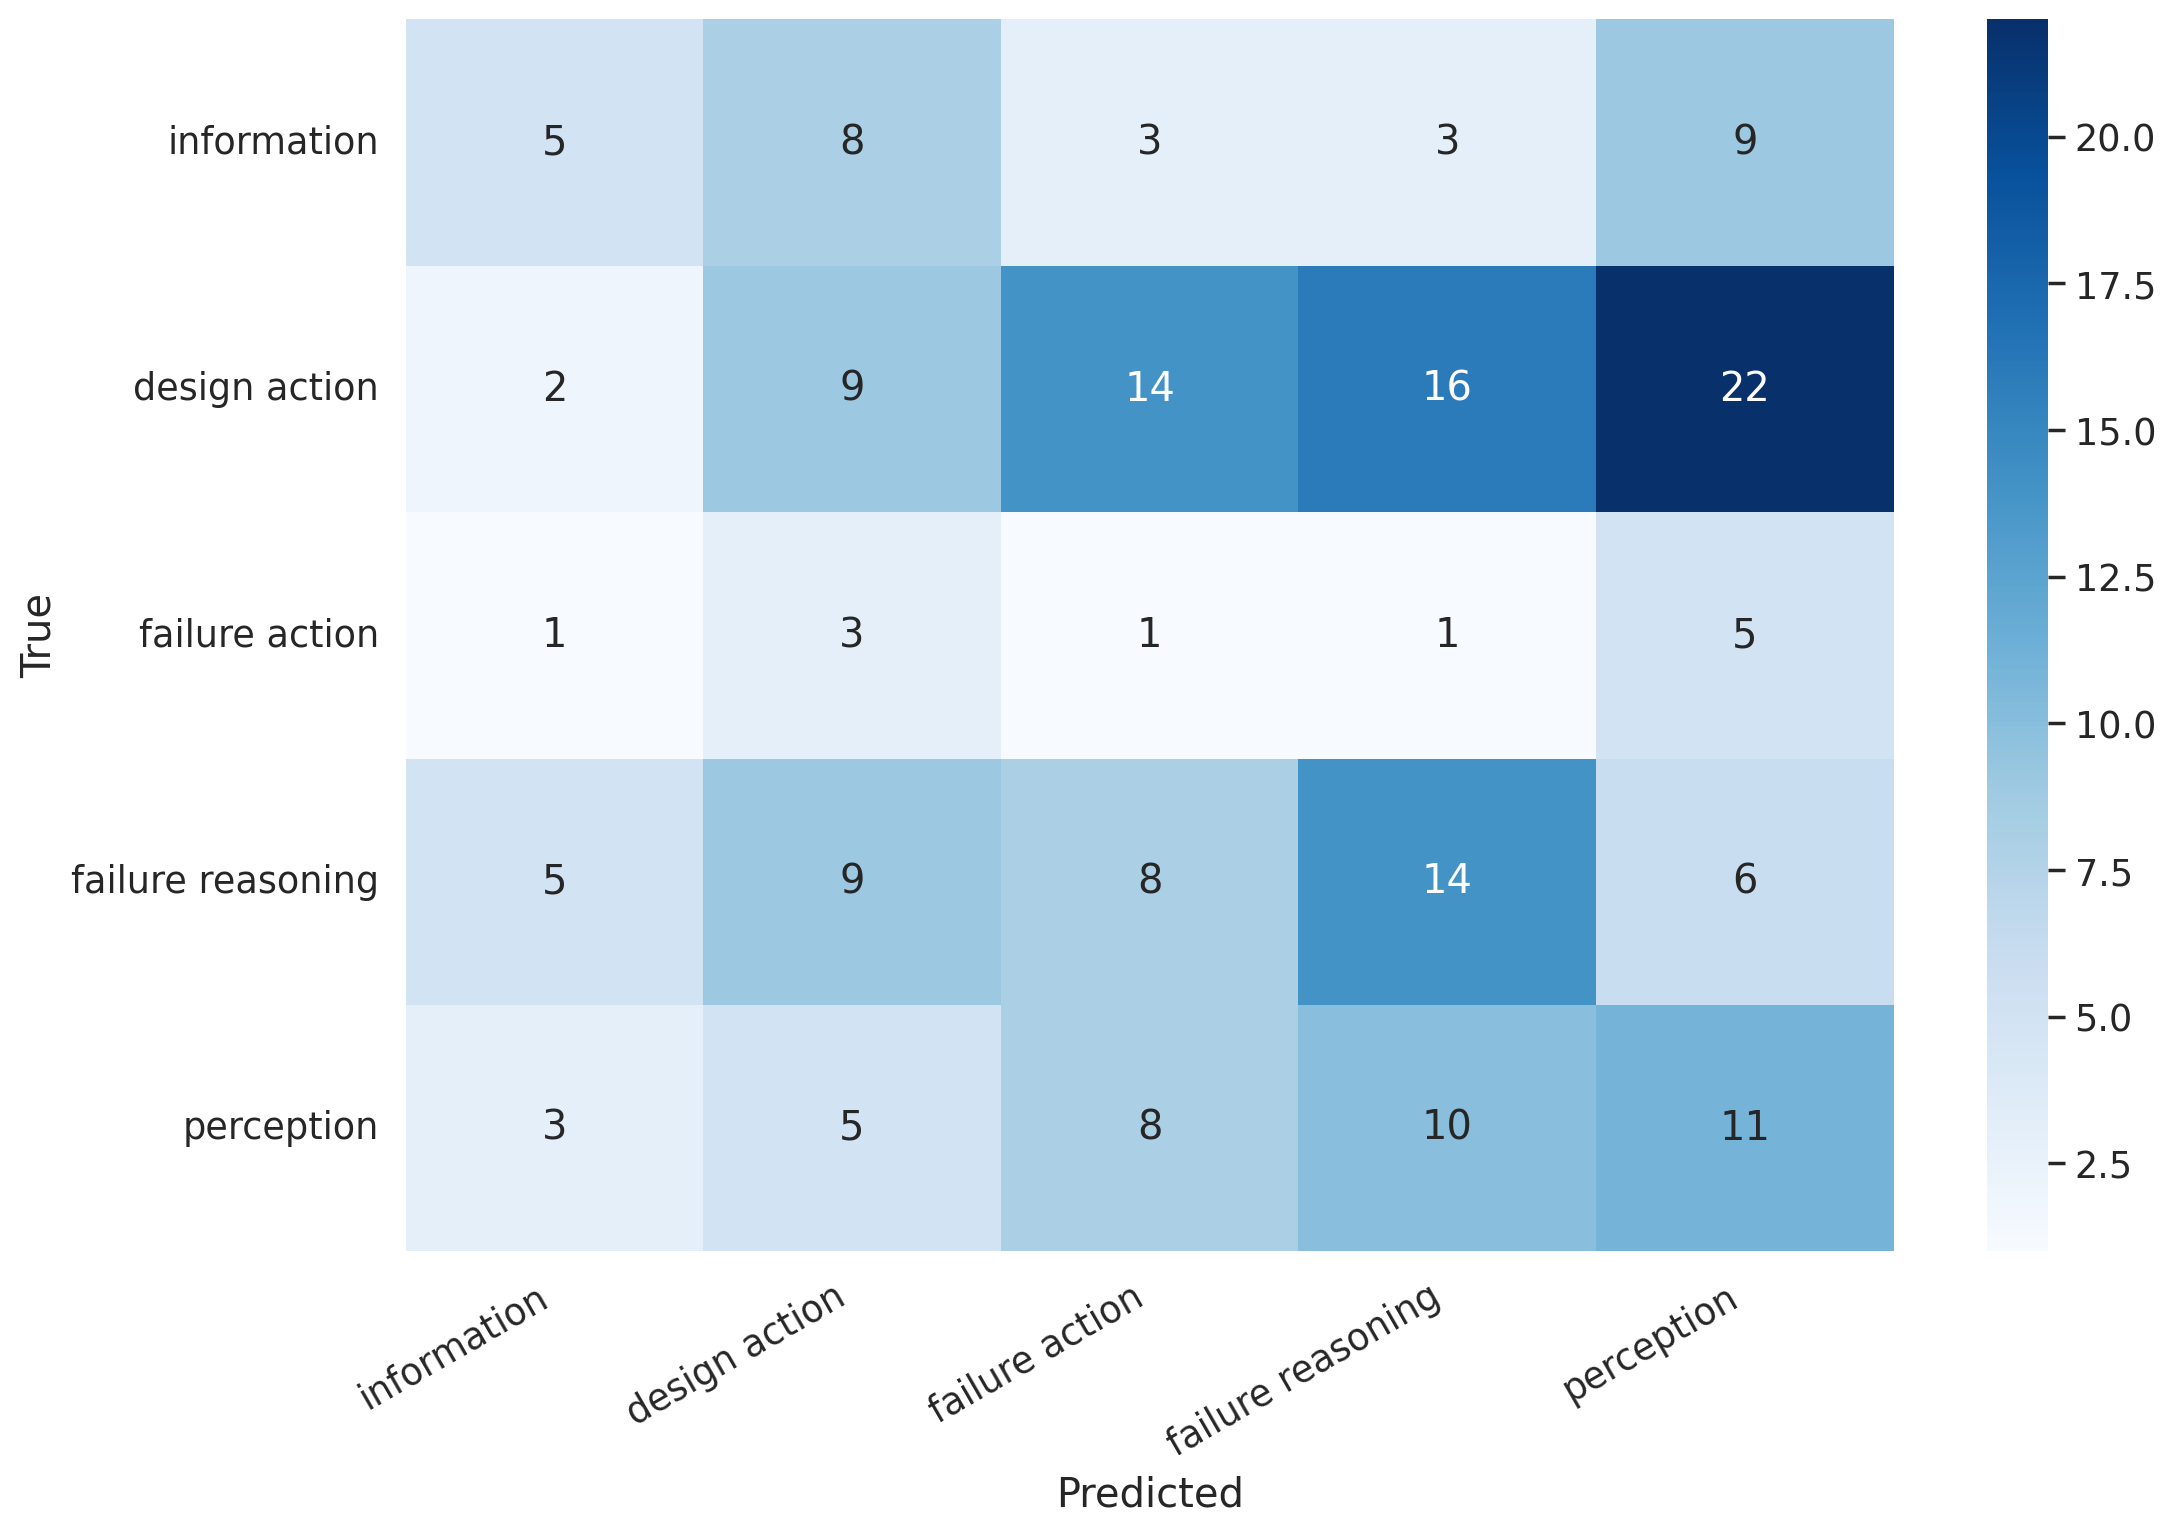

In [88]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [89]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.31      0.18      0.23        28
    design action       0.26      0.14      0.19        63
   failure action       0.03      0.09      0.04        11
failure reasoning       0.32      0.33      0.33        42
       perception       0.21      0.30      0.24        37

         accuracy                           0.22       181
        macro avg       0.23      0.21      0.21       181
     weighted avg       0.26      0.22      0.23       181

